Train label distribution: {'transmission with teeth-uncompleted gears': 1419, 'oval gear': 649, 'chain drive': 213, 'ratchet mechanism': 111, 'one way clutch': 53, 'pin rack drive': 37}
Val label distribution: {'transmission with teeth-uncompleted gears': 474, 'oval gear': 216, 'chain drive': 71, 'ratchet mechanism': 37, 'one way clutch': 18, 'pin rack drive': 12}
Test label distribution: {'transmission with teeth-uncompleted gears': 473, 'oval gear': 216, 'chain drive': 71, 'ratchet mechanism': 37, 'one way clutch': 18, 'pin rack drive': 13}
Class weights: [0.2915198504924774, 7.8050312995910645, 0.6373908519744873, 3.726726770401001, 1.9420970678329468, 11.180180549621582]
Trainable parameters: 3,468,742 / 4,066,566 (85.30%)
Starting training with Mixup and strong regularization...
Epoch 1: Train Loss 1.3251, Val Loss 1.0601, Train Acc 0.2378, Val Acc 0.1208, LR: 1.86e-02
✓ New best model! Val Acc: 0.1208
Epoch 2: Train Loss 1.1327, Val Loss 0.9418, Train Acc 0.2719, Val Acc 0.3430, 

C:\Users\shrin\AppData\Local\Temp\ipykernel_18484\3844271562.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_advanced.pth'


=== Test Results ===
Test Loss: 0.8815
Accuracy: 0.5833 | With TTA: 0.6002
Precision: 0.6532 | With TTA: 0.6687
Recall: 0.5833 | With TTA: 0.6002
F1-Score: 0.6009 | With TTA: 0.6182

=== Classification Report (with TTA) ===
                                           precision    recall  f1-score   support

transmission with teeth-uncompleted gears     0.7215    0.7230    0.7223       473
                           one way clutch     0.0789    0.3333    0.1277        18
                                oval gear     0.6810    0.3657    0.4759       216
                        ratchet mechanism     0.2027    0.4054    0.2703        37
                              chain drive     0.7385    0.6761    0.7059        71
                           pin rack drive     0.3043    0.5385    0.3889        13

                                 accuracy                         0.6002       828
                                macro avg     0.4545    0.5070    0.4485       828
                          

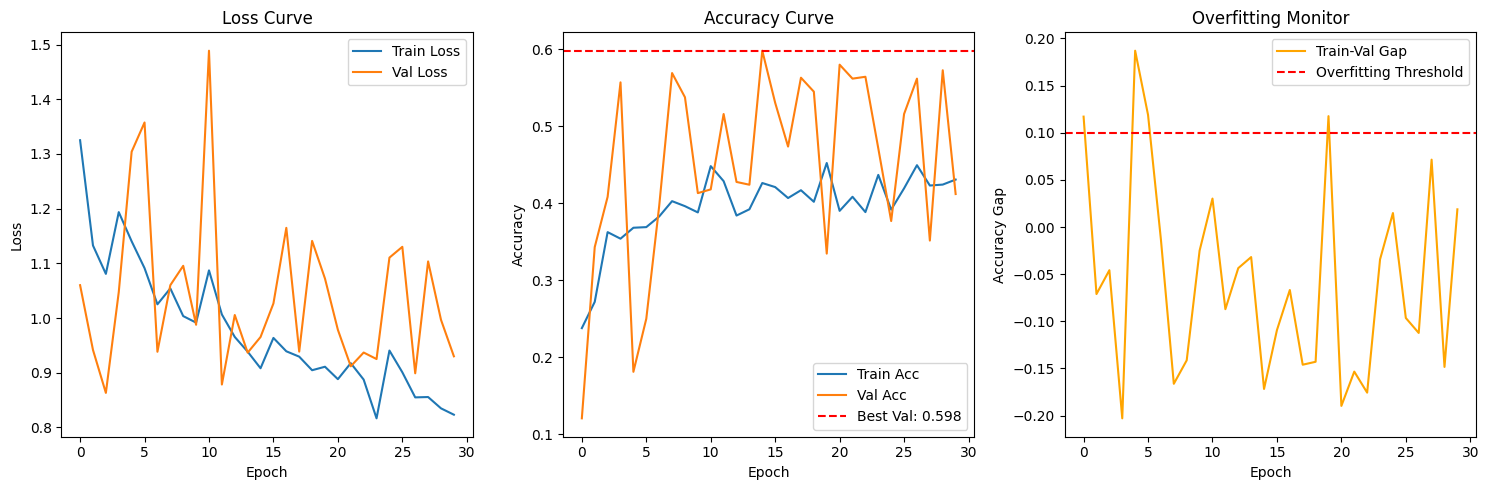

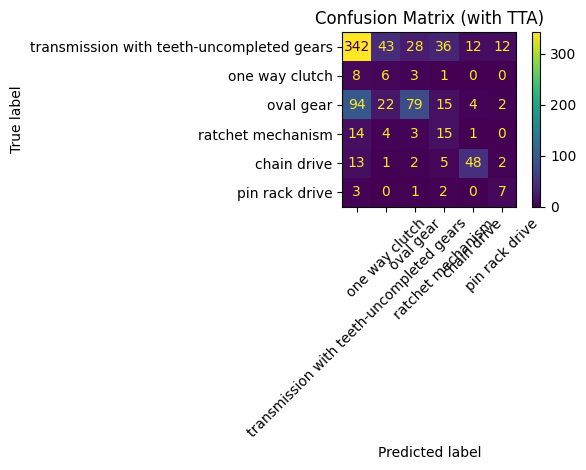

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import matplotlib.pyplot as plt

# =========================================================
# 1. Load CSV and Folder Paths
# =========================================================

metadata_path = r"C:\Users\shrin\OneDrive\Desktop\DL_2\updated_metadata_2d.csv"
data_root     = r"C:\Users\shrin\OneDrive\Desktop\DL_2\dataset_split_2d"
train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

df = pd.read_csv(metadata_path)

# Filter for 2D images
df = df[df["Sketch Type"].str.contains("2D", case=False, na=False)].reset_index(drop=True)
assert len(df) > 0, "No rows with Sketch Type == '2D' found!"

# Encode classes
class2idx = {c: i for i, c in enumerate(df['Class'].unique())}
idx2class = {i: c for c, i in class2idx.items()}
df['class_idx'] = df['Class'].map(class2idx)
num_classes = len(class2idx)

# Use existing split column
train_df = df[df["Split"] == "train"].reset_index(drop=True)
val_df   = df[df["Split"] == "val"].reset_index(drop=True)
test_df  = df[df["Split"] == "test"].reset_index(drop=True)

print("Train label distribution:", train_df['Class'].value_counts().to_dict())
print("Val label distribution:", val_df['Class'].value_counts().to_dict())
print("Test label distribution:", test_df['Class'].value_counts().to_dict())

# =========================================================
# 2. STRONG Data Augmentation
# =========================================================
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# =========================================================
# 3. Custom Dataset
# =========================================================
class MechDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.bert_cols = [c for c in self.df.columns if c.startswith('bert_emb_')]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fname = self.df.loc[idx, 'File Name']
        img_path = os.path.join(self.img_dir, fname)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.df.loc[idx, 'class_idx']
        bert_emb = torch.tensor(self.df.loc[idx, self.bert_cols].values.astype(np.float32))
        return image, bert_emb, label

# =========================================================
# 4. Datasets + Loaders with MIXUP AUGMENTATION
# =========================================================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

train_set = MechDataset(train_df, train_dir, transform=train_transform)
val_set   = MechDataset(val_df, val_dir, transform=eval_transform)
test_set  = MechDataset(test_df, test_dir, transform=eval_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=32, shuffle=False)

# =========================================================
# 5. Class weights
# =========================================================
all_train_labels = train_df['class_idx'].values
class_weights = compute_class_weight('balanced', classes=np.unique(all_train_labels), y=all_train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights.tolist())

# =========================================================
# 6. Improved Loss with CUTMIX ready
# =========================================================
class ImprovedFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, smoothing=0.1, reduction='mean'):
        super(ImprovedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none', label_smoothing=smoothing)

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# =========================================================
# 7. OPTIMIZED Architecture with BETTER Regularization (MobileNet-V2)
# =========================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class OptimizedModel(nn.Module):
    def __init__(self, num_classes, bert_emb_dim, dropout_rate=0.6):
        super().__init__()

        # Use MobileNet-V2 backbone
        self.backbone = models.mobilenet_v2(
            weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
        )

        # Freeze first 3/4 of parameters
        total_params = sum(1 for _ in self.backbone.parameters())
        freeze_until = int(total_params * 0.75)

        for i, (name, param) in enumerate(self.backbone.named_parameters()):
            if i < freeze_until:
                param.requires_grad = False
            else:
                param.requires_grad = True

        # Extract feature dimension from MobileNet-V2 head
        self.img_feature_dim = self.backbone.classifier[1].in_features

        # Remove the classifier head
        self.backbone.classifier = nn.Identity()

        # Enhanced classifier with BATCH NORM and DROPOUT (unchanged structure)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.img_feature_dim + bert_emb_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),

            nn.Dropout(dropout_rate - 0.1),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            nn.Dropout(dropout_rate - 0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, bert_emb):
        img_features = self.backbone(x)
        combined = torch.cat([img_features, bert_emb], dim=1)
        return self.classifier(combined)

bert_emb_dim = len([c for c in df.columns if c.startswith('bert_emb_')])
model = OptimizedModel(num_classes=num_classes, bert_emb_dim=bert_emb_dim, dropout_rate=0.6)
model = model.to(device)

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")

# =========================================================
# 8. ADVANCED Training Setup
# =========================================================
criterion = ImprovedFocalLoss(alpha=class_weights.to(device), gamma=2.0, smoothing=0.1)

# Use SGD with momentum for better generalization
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.001,
    nesterov=True
)

# OneCycle LR scheduler for faster convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,
    epochs=50,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    div_factor=10,
    final_div_factor=100
)

# Gradient clipping
max_grad_norm = 1.0

# =========================================================
# 9. TRAINING with MIXUP and STRONG Regularization
# =========================================================
best_val_acc = 0.0
best_val_loss = float('inf')
patience = 15
epochs_no_improve = 0
n_epochs = 50

train_losses, val_losses, train_accs, val_accs = [], [], [], []

print("Starting training with Mixup and strong regularization...")

for epoch in range(n_epochs):
    # Training phase with MIXUP
    model.train()
    running_loss, total, correct = 0, 0, 0
    
    for X, bert_emb, y in train_loader:
        X, bert_emb, y = X.to(device), bert_emb.to(device), y.to(device)
        
        # Apply Mixup augmentation
        if np.random.random() > 0.5:  # 50% chance to use mixup
            X_mixed, y_a, y_b, lam = mixup_data(X, y, alpha=0.2)
            optimizer.zero_grad()
            out = model(X_mixed, bert_emb)
            loss = mixup_criterion(criterion, out, y_a, y_b, lam)
        else:
            optimizer.zero_grad()
            out = model(X, bert_emb)
            loss = criterion(out, y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(out, 1)
        correct += (preds == y).sum().item()
        total += X.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation phase (no mixup)
    model.eval()
    val_loss_sum, val_total, val_correct = 0, 0, 0
    with torch.no_grad():
        for X_val, bert_emb_val, y_val in val_loader:
            X_val, bert_emb_val, y_val = X_val.to(device), bert_emb_val.to(device), y_val.to(device)
            out_val = model(X_val, bert_emb_val)
            loss_val = criterion(out_val, y_val)
            val_loss_sum += loss_val.item() * X_val.size(0)
            _, preds_val = torch.max(out_val, 1)
            val_correct += (preds_val == y_val).sum().item()
            val_total += X_val.size(0)

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, "
          f"Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}, LR: {current_lr:.2e}")

    # Save best model based on validation accuracy
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_advanced.pth')
        epochs_no_improve = 0
        print(f"✓ New best model! Val Acc: {val_acc:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Stop if severe overfitting detected
    if train_acc > 0.95 and val_acc < 0.7 and epoch > 10:
        print("Severe overfitting detected, stopping early")
        break

print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# =========================================================
# 10. TEST with TTA (Test Time Augmentation)
# =========================================================
model.load_state_dict(torch.load('best_model_advanced.pth', map_location=device))
model.eval()

def predict_with_tta(model, X, bert_emb, n_augments=5):
    """Test Time Augmentation for better performance"""
    predictions = []
    
    # Original image
    with torch.no_grad():
        pred = model(X, bert_emb)
        predictions.append(pred)
    
    # Augmented versions
    tta_transforms = [
        transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)]),
        transforms.Compose([transforms.RandomRotation(10)]),
        transforms.Compose([transforms.ColorJitter(brightness=0.1, contrast=0.1)]),
    ]
    
    for transform in tta_transforms[:n_augments-1]:
        X_aug = torch.stack([transform(x.cpu()) for x in X]).to(device)
        with torch.no_grad():
            pred = model(X_aug, bert_emb)
            predictions.append(pred)
    
    # Average predictions
    return torch.stack(predictions).mean(0)

y_true, y_pred, y_pred_tta = [], [], []
test_loss_sum = 0

with torch.no_grad():
    for X, bert_emb, y in test_loader:
        X, bert_emb, y = X.to(device), bert_emb.to(device), y.to(device)
        
        # Regular prediction
        out = model(X, bert_emb)
        loss = criterion(out, y)
        test_loss_sum += loss.item() * X.size(0)
        
        # TTA prediction
        out_tta = predict_with_tta(model, X, bert_emb)
        
        preds = torch.argmax(out, 1).cpu().numpy()
        preds_tta = torch.argmax(out_tta, 1).cpu().numpy()
        
        y_pred.extend(preds)
        y_pred_tta.extend(preds_tta)
        y_true.extend(y.cpu().numpy())

test_loss = test_loss_sum / len(test_loader.dataset)

# Calculate metrics for both regular and TTA
accuracy = accuracy_score(y_true, y_pred)
accuracy_tta = accuracy_score(y_true, y_pred_tta)

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
precision_tta, recall_tta, f1_tta, _ = precision_recall_fscore_support(y_true, y_pred_tta, average='weighted')

print(f"\n=== Test Results ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f} | With TTA: {accuracy_tta:.4f}")
print(f"Precision: {precision:.4f} | With TTA: {precision_tta:.4f}")
print(f"Recall: {recall:.4f} | With TTA: {recall_tta:.4f}")
print(f"F1-Score: {f1:.4f} | With TTA: {f1_tta:.4f}")

# Use TTA results for final report
report = classification_report(
    y_true,
    y_pred_tta,  # Use TTA predictions
    target_names=[idx2class[i] for i in range(len(idx2class))],
    digits=4
)
print("\n=== Classification Report (with TTA) ===")
print(report)

# Save results
with open("classification_report_advanced.txt", "w") as f:
    f.write(f"Test Accuracy: {accuracy_tta:.4f}\n")
    f.write(f"Test Precision: {precision_tta:.4f}\n")
    f.write(f"Test Recall: {recall_tta:.4f}\n")
    f.write(f"Test F1-Score: {f1_tta:.4f}\n\n")
    f.write(report)

# ---- New Section: Per-Class Classification Report ----
report = classification_report(
    y_true,
    y_pred,
    target_names=[idx2class[i] for i in range(len(idx2class))],
    digits=4
)
print("\n=== Classification Report ===")
print(report)

# Save to text file
with open("classification_report.txt", "w") as f:
    f.write(report)

# =========================================================
# 11. Enhanced Plots
# =========================================================
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best Val: {best_val_acc:.3f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1, 3, 3)
# Plot accuracy gap (overfitting indicator)
gap = [train_accs[i] - val_accs[i] for i in range(len(train_accs))]
plt.plot(gap, label='Train-Val Gap', color='orange')
plt.axhline(y=0.1, color='r', linestyle='--', label='Overfitting Threshold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap')
plt.legend()
plt.title('Overfitting Monitor')

plt.tight_layout()
plt.show()

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_tta)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=[idx2class[i] for i in range(len(idx2class))])
disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix (with TTA)')
plt.tight_layout()
plt.show()
